Using the following extension datasets:


https://data.boston.gov/dataset/property-assessment/resource/1000d81c-5bb5-49e8-a9ab-44cd042f1db2


https://data.boston.gov/dataset/economic-indicators-legacy-portal/resource/29e74884-a777-4242-9fcc-c30aaaf3fb10


https://data.boston.gov/dataset/boston-zoning-subdistricts

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

In [78]:
appeals_df = pd.read_csv('../data/zoning_board_appeals_tracker.csv')
a80_df = pd.read_csv('../data/Article80_Development_Projects.csv')
zoning_df = pd.read_csv('../data/Boston_Zoning_Subdistricts.csv')
econ_df = pd.read_csv('../data/economic-indicators.csv')
housing_df = pd.read_csv('../data/fy2023-property-assessment-data.csv')

In [79]:
denied_df = appeals_df.query('decision == "Denied" | decision == "DeniedPrej"')

appeals_df['submitted_year'] = pd.to_datetime(appeals_df['submitted_date']).dt.year
denied_df['submitted_year'] = pd.to_datetime(denied_df['submitted_date']).dt.year
appeals_df['submitted_month'] = pd.to_datetime(appeals_df['submitted_date']).dt.month
denied_df['submitted_month'] = pd.to_datetime(denied_df['submitted_date']).dt.month
appeals_df['submitted_month_year'] = pd.to_datetime(appeals_df['submitted_date']).dt.to_period('M')
denied_df['submitted_month_year'] = pd.to_datetime(denied_df['submitted_date']).dt.to_period('M')

/tmp/ipykernel_34046/2029000917.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  denied_df['submitted_year'] = pd.to_datetime(denied_df['submitted_date']).dt.year
/tmp/ipykernel_34046/2029000917.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  denied_df['submitted_month'] = pd.to_datetime(denied_df['submitted_date']).dt.month
/tmp/ipykernel_34046/2029000917.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [80]:
econ_df['date'] = [f'{y}-{m}-01' for y, m in zip(econ_df['Year'], econ_df['Month'])]

econ_df['month_year'] = pd.to_datetime(econ_df['date']).dt.to_period('M')
econ_df['month_year'] = pd.to_datetime(econ_df['date']).dt.to_period('M')
econ_df['timestamp'] = [t.to_timestamp() for t in econ_df['month_year']]

In [81]:
def plot_econ_feature_vs_approval(feature, denial_rate=True):
    times = sorted([year for year in list(set(appeals_df['submitted_month_year']))])

    x_vals = []
    y_vals = []
    for year in times[1:]:
        if year.to_timestamp() < max(econ_df['timestamp']):
            x_vals.append(year.to_timestamp())
            y_vals.append(
                (denied_df[denied_df['submitted_month_year'] == year].shape[0]) / (appeals_df[appeals_df['submitted_month_year'] == year].shape[0])
            )

    fig, ax1 = plt.subplots(figsize=(9, 6))
    ax2 = ax1.twinx() 
    ax1.plot(x_vals, y_vals, label='Approval Rate')
    ax2.plot(econ_df['timestamp'], econ_df[feature], color='red', label=feature)
    fig.legend()
    ax1.set_title(f'Approval Rate and {feature}')
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Approval Rate")
    ax2.set_ylabel(f"{feature}")
    fig.show()

/tmp/ipykernel_34046/2585752101.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


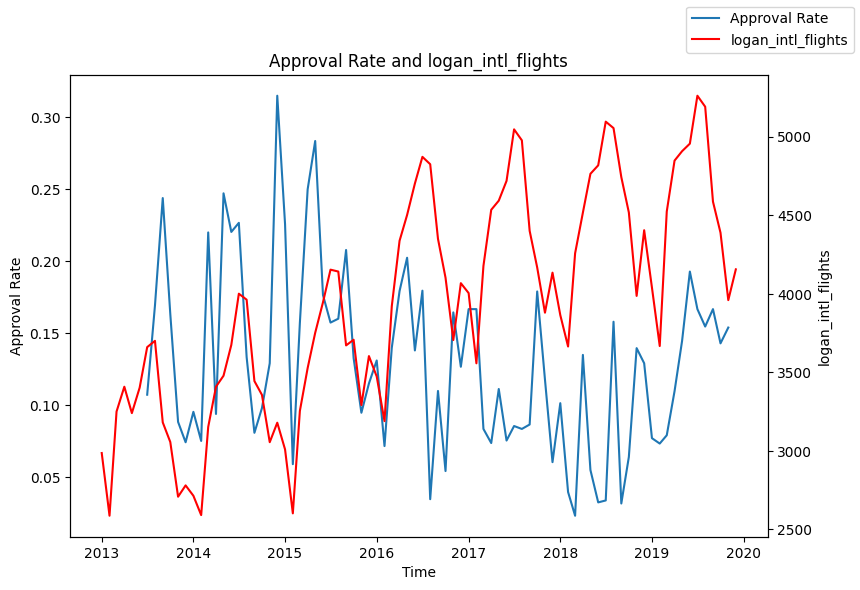

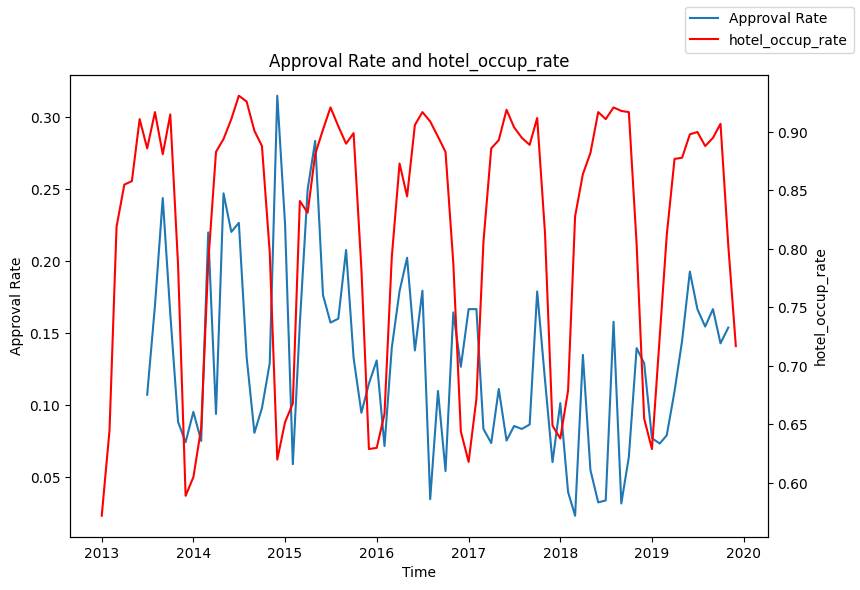

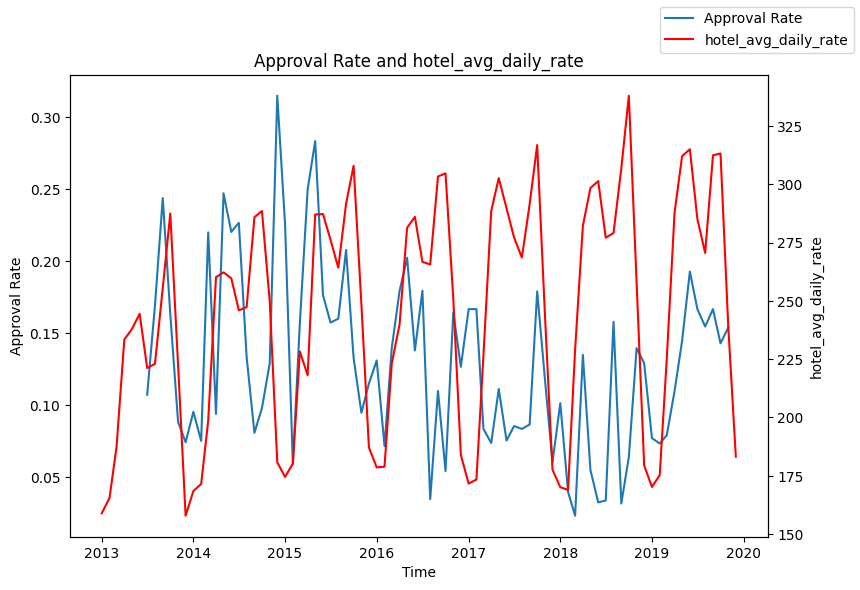

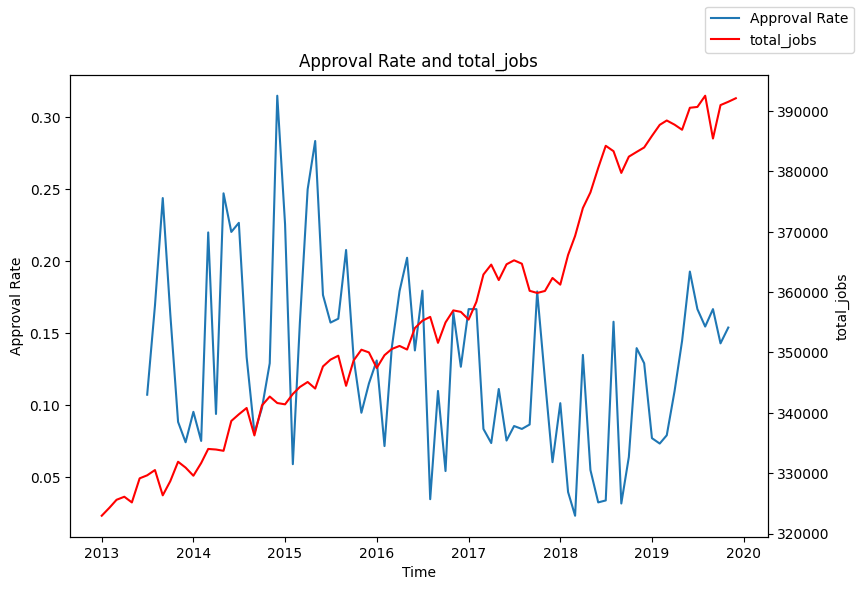

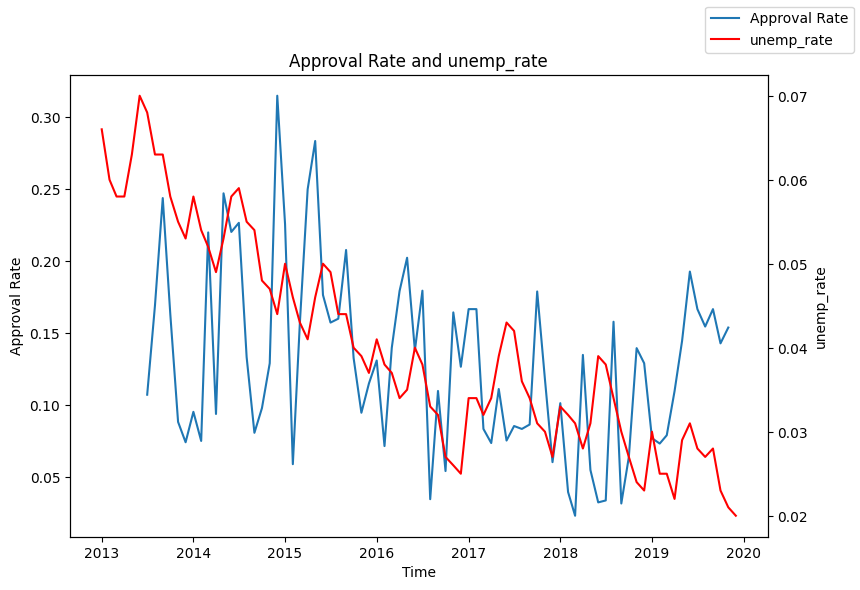

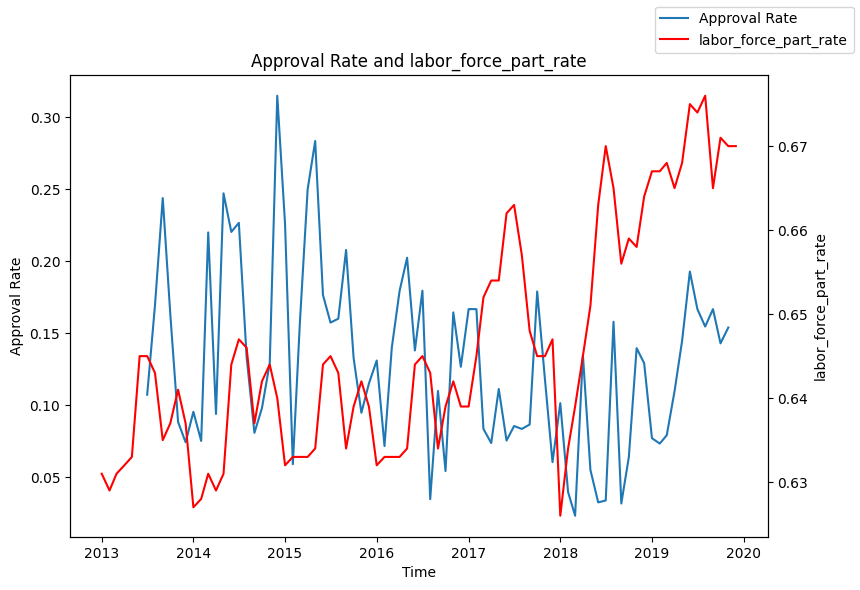

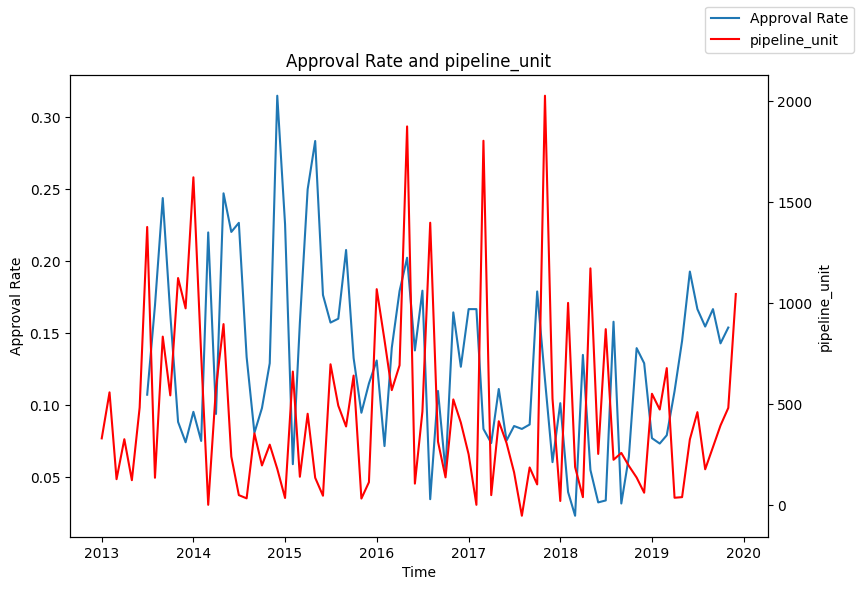

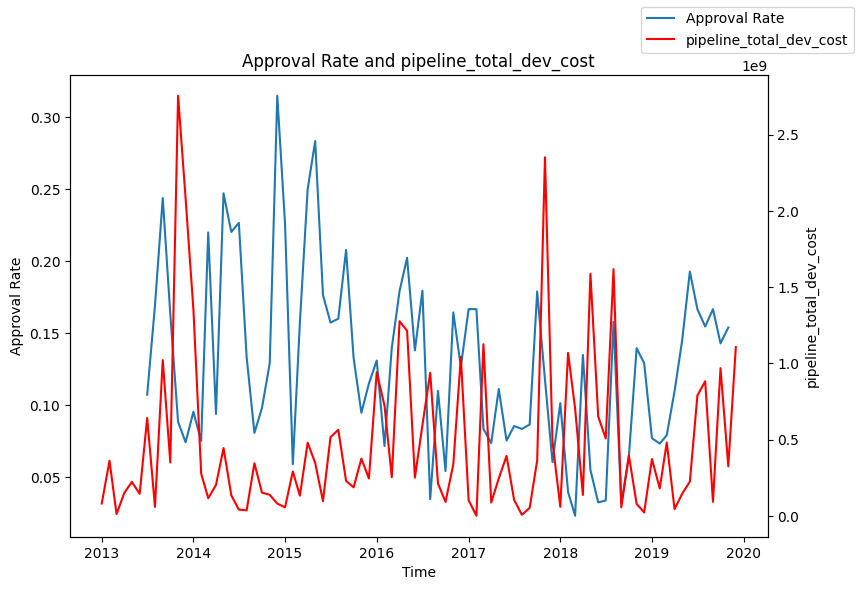

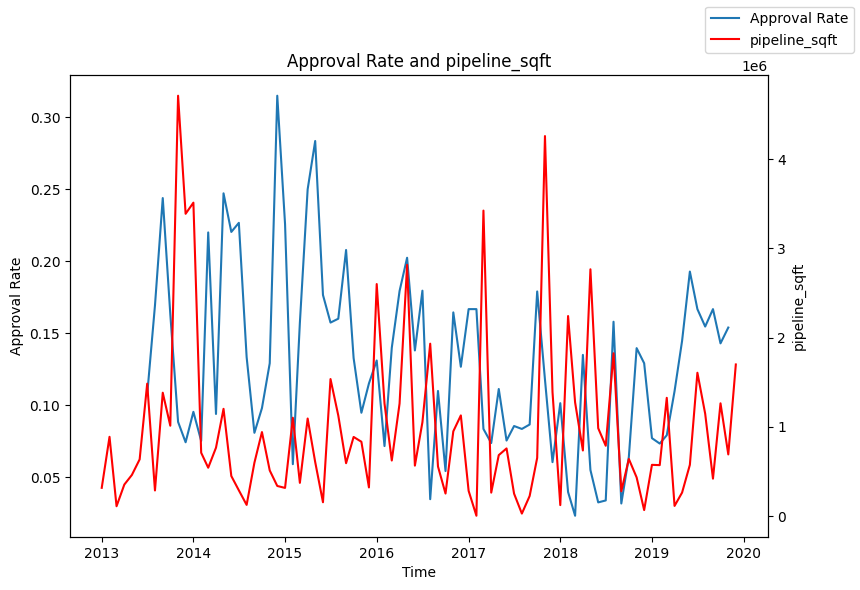

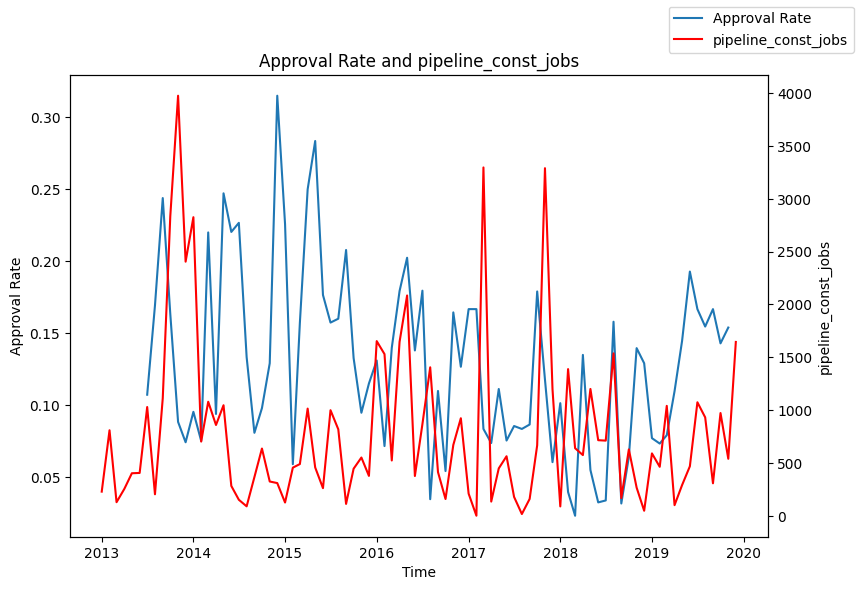

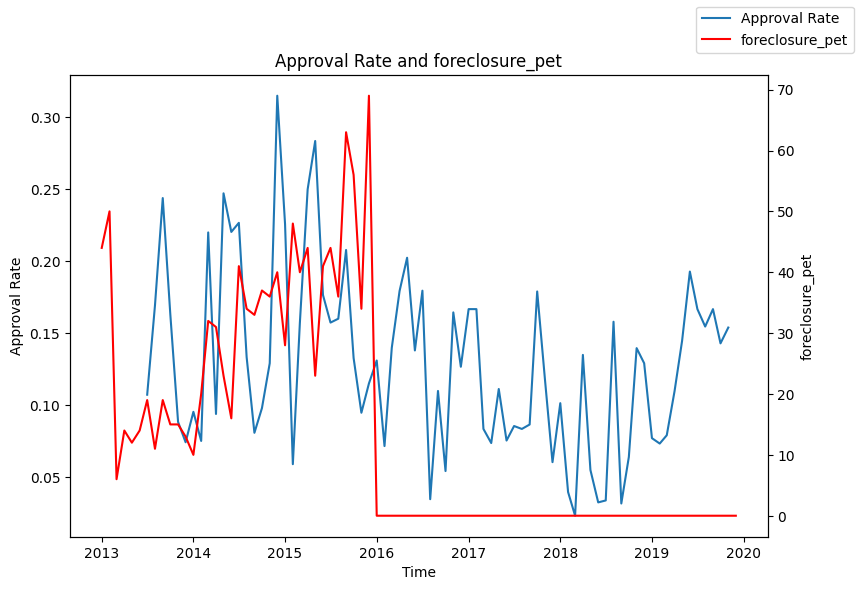

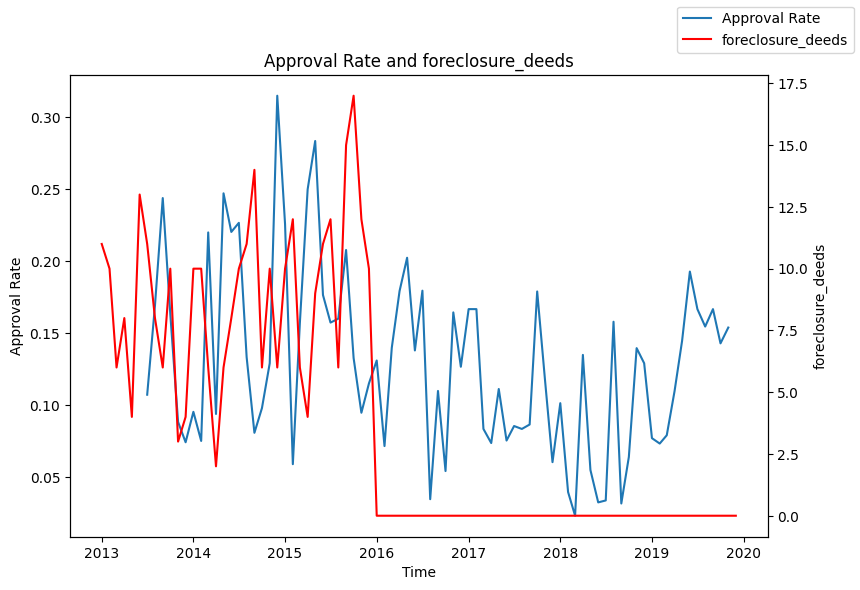

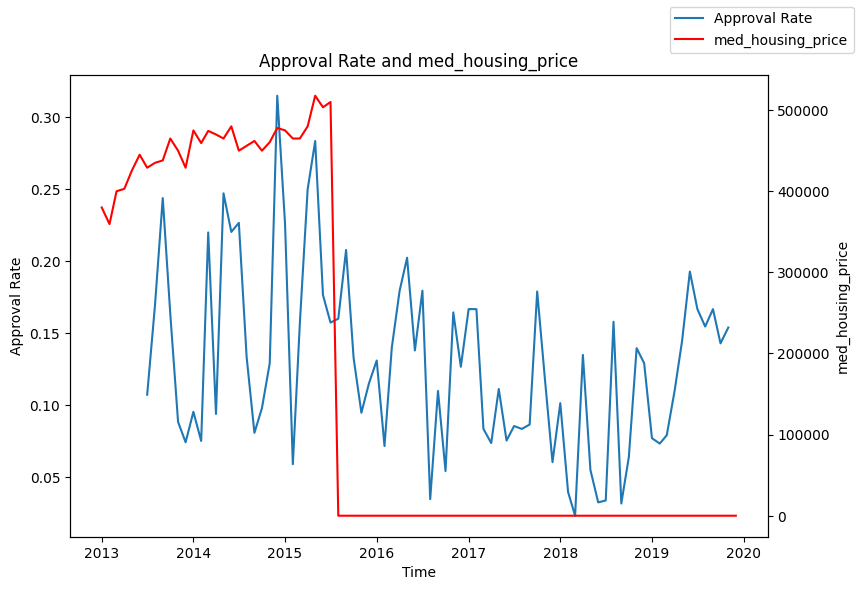

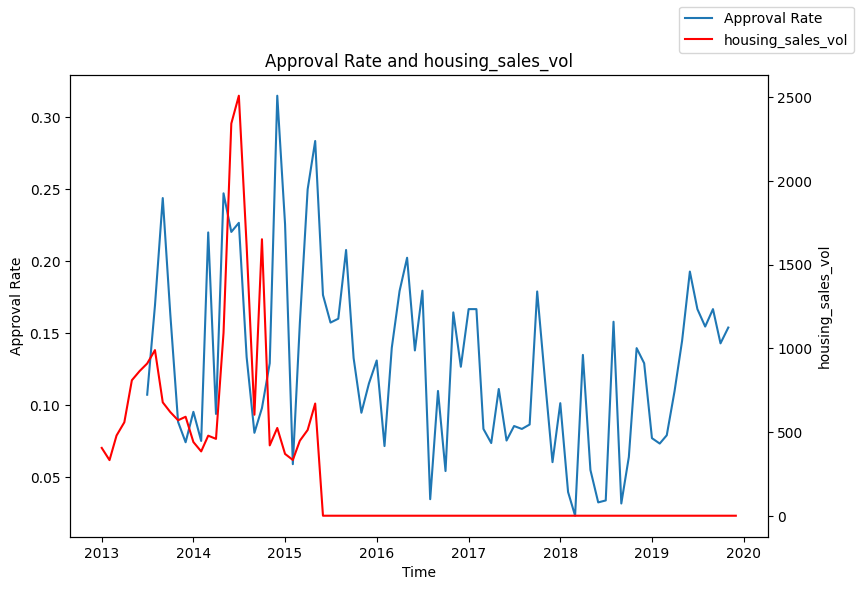

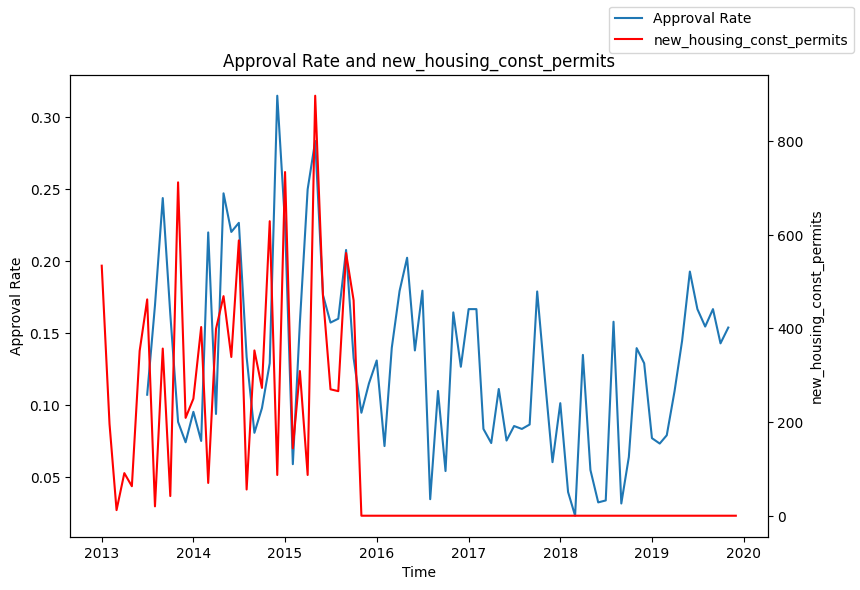

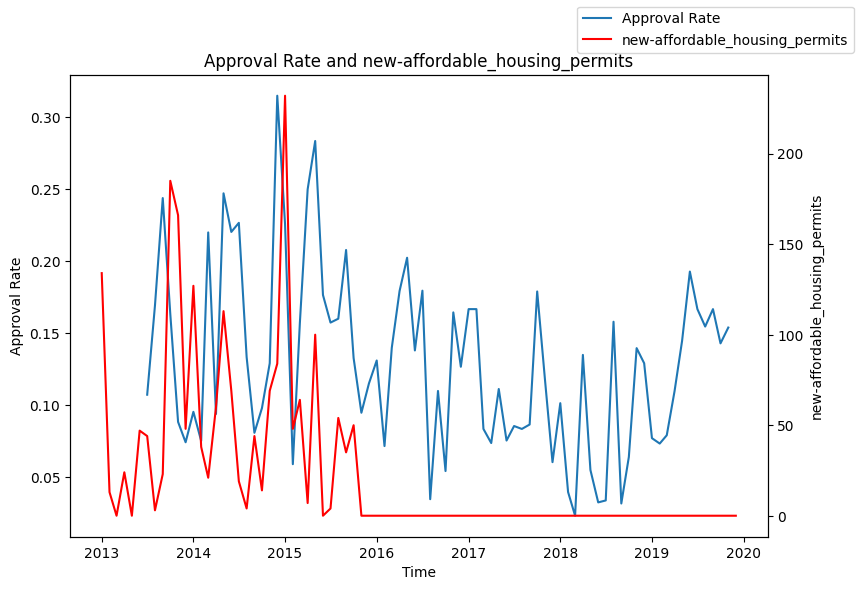

In [82]:
for feature in econ_df.columns[3:-3]:
    plot_econ_feature_vs_approval(feature)

In [83]:
clean_econ_df = econ_df.drop(
    axis=1,
    labels=['foreclosure_pet',
       'foreclosure_deeds', 'med_housing_price', 'housing_sales_vol',
       'new_housing_const_permits', 'new-affordable_housing_permits']
)

econ_dct = dict.fromkeys(set(econ_df['Year']))
for k in econ_dct.keys():
    econ_dct[k] = dict.fromkeys(set(econ_df['Month']))
    for k2 in econ_dct[k].keys():
        econ_dct[k][k2] = dict.fromkeys(clean_econ_df.columns)
        for f in clean_econ_df.columns:
            tmp = econ_df.query(f"Year == {k} and Month == {k2}")[f]
            assert len(tmp) == 1
            econ_dct[k][k2][f] = tmp.to_numpy()[0]

In [84]:
housing_df.head()

,PID,CM_ID,GIS_ID,ST_NUM,ST_NAME,UNIT_NUM,CITY,ZIP_CODE,BLDG_SEQ,NUM_BLDGS,...,KITCHEN_STYLE2,KITCHEN_STYLE3,HEAT_TYPE,HEAT_FUEL,AC_TYPE,FIREPLACES,ORIENTATION,NUM_PARKING,PROP_VIEW,CORNER_UNIT
0,100001000,NaN,100001000,104.0,PUTNAM ST,NaN,EAST BOSTON,2128.0,1.0,1,...,S - Semi-Modern,S - Semi-Modern,W - Ht Water/Steam,NaN,N - None,0.0,NaN,3.0,A - Average,NaN
1,100002000,NaN,100002000,197.0,Lexington ST,NaN,EAST BOSTON,2128.0,1.0,1,...,M - Modern,M - Modern,F - Forced Hot Air,NaN,C - Central AC,0.0,NaN,0.0,A - Average,NaN
2,100003000,NaN,100003000,199.0,Lexington ST,NaN,EAST BOSTON,2128.0,1.0,1,...,S - Semi-Modern,S - Semi-Modern,S - Space Heat,NaN,N - None,0.0,NaN,0.0,A - Average,NaN
3,100004000,NaN,100004000,201.0,Lexington ST,NaN,EAST BOSTON,2128.0,1.0,1,...,S - Semi-Modern,S - Semi-Modern,W - Ht Water/Steam,NaN,N - None,0.0,NaN,0.0,A - Average,NaN
4,100005000,NaN,100005000,203.0,Lexington ST,NaN,EAST BOSTON,2128.0,1.0,1,...,S - Semi-Modern,NaN,W - Ht Water/Steam,NaN,N - None,0.0,NaN,0.0,A - Average,NaN


In [85]:
housing_df = housing_df.dropna(axis=0, subset=['ST_NUM', 'ZIP_CODE'])
housing_df['address'] = \
    [f"{num} {st} {town} {zipcode}".lower() for num, st, town, zipcode in zip(housing_df['ST_NUM'].astype(int), housing_df['ST_NAME'], housing_df['CITY'], housing_df['ZIP_CODE'].astype(int))]

appeals_df['address'] = [a.lower() for a in appeals_df['address']]

In [86]:
print(housing_df.columns)

Index(['PID', 'CM_ID', 'GIS_ID', 'ST_NUM', 'ST_NAME', 'UNIT_NUM', 'CITY',
       'ZIP_CODE', 'BLDG_SEQ', 'NUM_BLDGS', 'LUC', 'LU', 'LU_DESC',
       'BLDG_TYPE', 'OWN_OCC', 'OWNER', 'OWNER MAIL ADDRESS', 'RES_FLOOR',
       'CD_FLOOR', 'RES_UNITS', 'COM_UNITS', 'RC_UNITS', 'LAND_SF',
       'GROSS_AREA', 'LIVING_AREA', 'LAND_VALUE', 'BLDG_VALUE', 'TOTAL_VALUE',
       'GROSS_TAX', 'YR_BUILT', 'YR_REMODEL', 'STRUCTURE_CLASS',
       'ROOF_STRUCTURE', 'ROOF_COVER', 'INT_WALL', 'EXT_FNISHED', 'INT_COND',
       'EXT_COND', 'OVERALL_COND', 'BED_RMS', 'FULL_BTH', 'HLF_BTH',
       'KITCHENS', 'TT_RMS', 'BDRM_COND', 'BTHRM_STYLE1', 'BTHRM_STYLE2',
       'BTHRM_STYLE3', 'KITCHEN_TYPE', 'KITCHEN_STYLE1', 'KITCHEN_STYLE2',
       'KITCHEN_STYLE3', 'HEAT_TYPE', 'HEAT_FUEL', 'AC_TYPE', 'FIREPLACES',
       'ORIENTATION', 'NUM_PARKING', 'PROP_VIEW', 'CORNER_UNIT', 'address'],
      dtype='object')


In [87]:
# Categorize by zip code
housing_dct = dict.fromkeys(set(housing_df['ZIP_CODE'].astype(int)))
for z in set(housing_df['ZIP_CODE'].astype(int)):
    housing_dct[z] = dict() 

# The features we care about
housing_features = ['RES_FLOOR',
       'CD_FLOOR', 'RES_UNITS', 'COM_UNITS', 'RC_UNITS', 'LAND_SF',
       'GROSS_AREA', 'LIVING_AREA', 'LAND_VALUE', 'BLDG_VALUE', 'TOTAL_VALUE',
       'GROSS_TAX', 'YR_BUILT', 'YR_REMODEL', 'FULL_BTH', 'HLF_BTH',
       'KITCHENS', 'TT_RMS', 'FIREPLACES', 'NUM_PARKING']

for z in set(housing_df['ZIP_CODE']):
    for f in housing_features:
        housing_dct[z][f] = np.mean(housing_df[housing_df['ZIP_CODE'] == z][f])

In [88]:
for f in housing_features:
    appeals_df[f] = [housing_dct[z][f] if z in housing_dct.keys() else 0 for z in appeals_df['zip']]

denied_df = appeals_df.query('decision == "Denied" | decision == "DeniedPrej"')

In [89]:
print(clean_econ_df.columns)
econ_features = ['logan_passengers', 'logan_intl_flights',
       'hotel_occup_rate', 'hotel_avg_daily_rate', 'total_jobs', 'unemp_rate',
       'labor_force_part_rate', 'pipeline_unit', 'pipeline_total_dev_cost',
       'pipeline_sqft', 'pipeline_const_jobs']

Index(['Year', 'Month', 'logan_passengers', 'logan_intl_flights',
       'hotel_occup_rate', 'hotel_avg_daily_rate', 'total_jobs', 'unemp_rate',
       'labor_force_part_rate', 'pipeline_unit', 'pipeline_total_dev_cost',
       'pipeline_sqft', 'pipeline_const_jobs', 'date', 'month_year',
       'timestamp'],
      dtype='object')


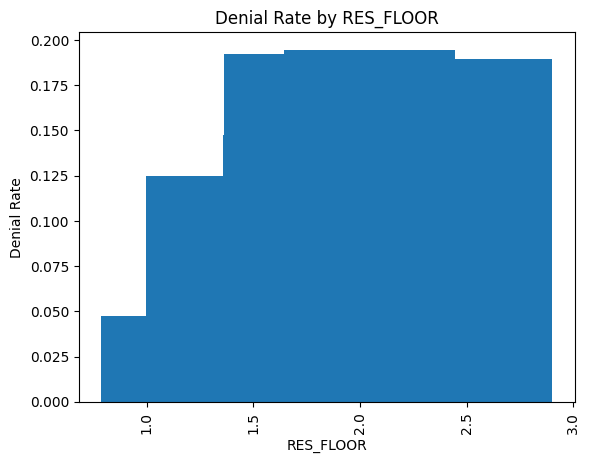

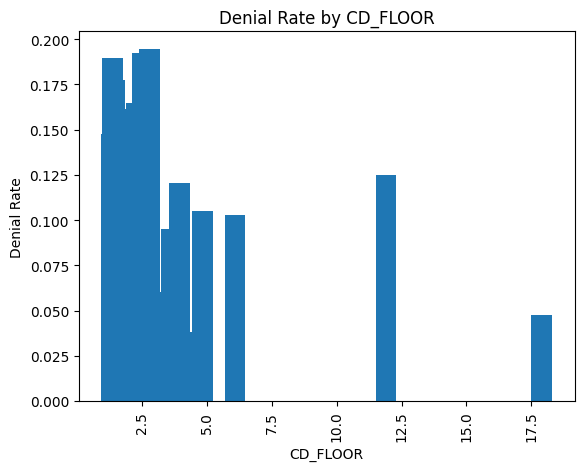

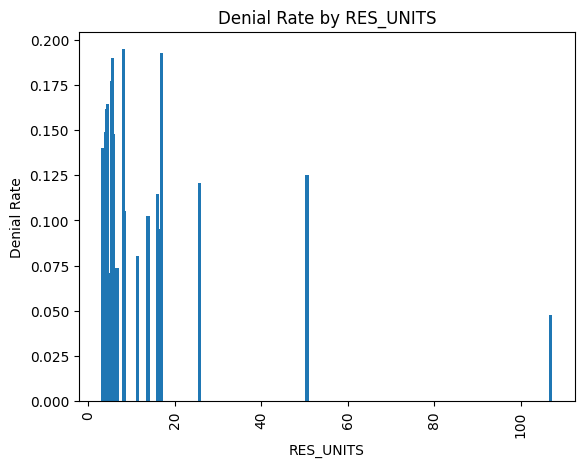

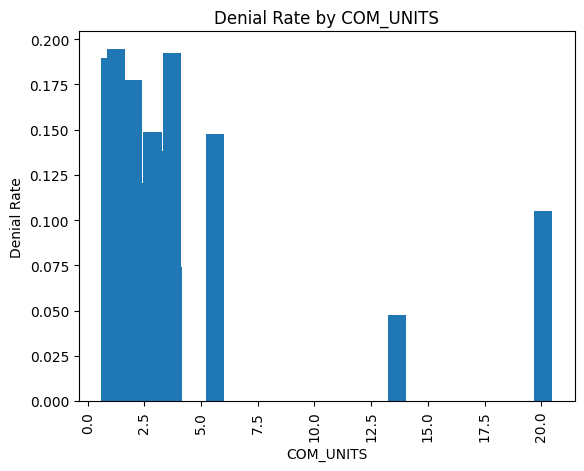

/tmp/ipykernel_34046/1158755508.py:9: RuntimeWarning: invalid value encountered in scalar divide
  ((df[df[column_name] == label][column_name].count()) / (appeals_df[appeals_df[column_name] == label].shape[0])) for label in labels


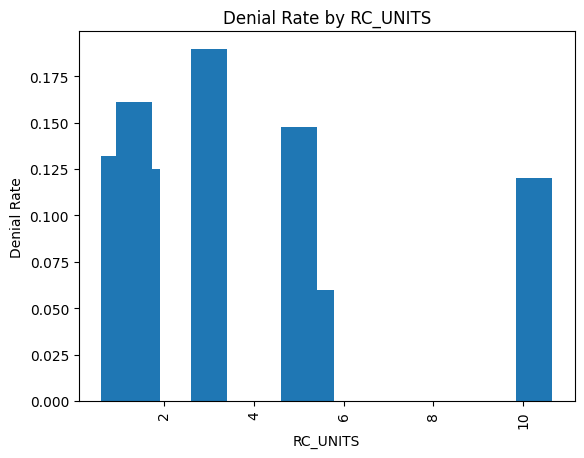

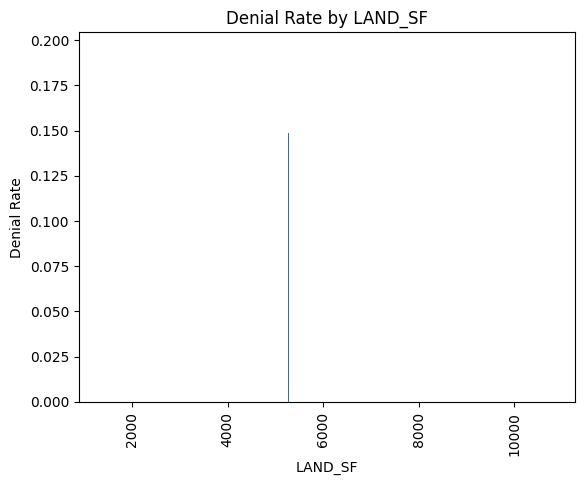

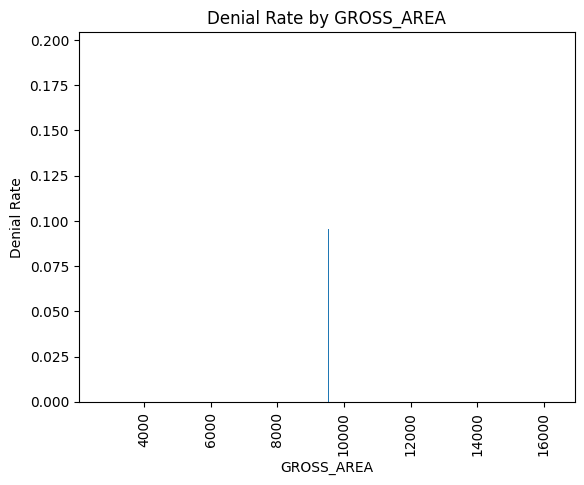

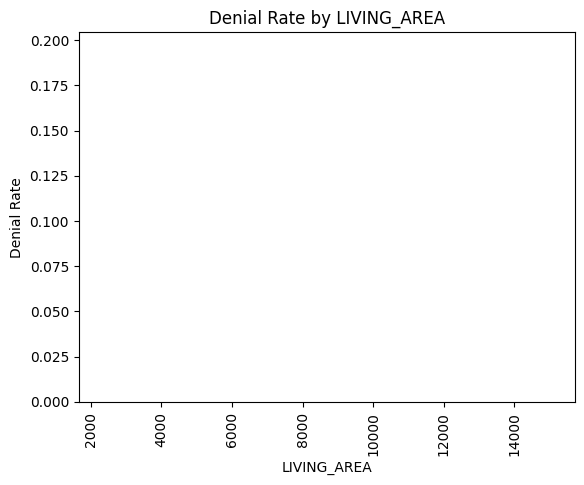

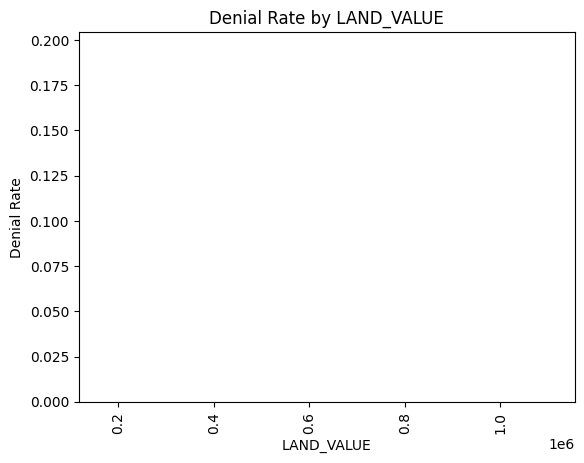

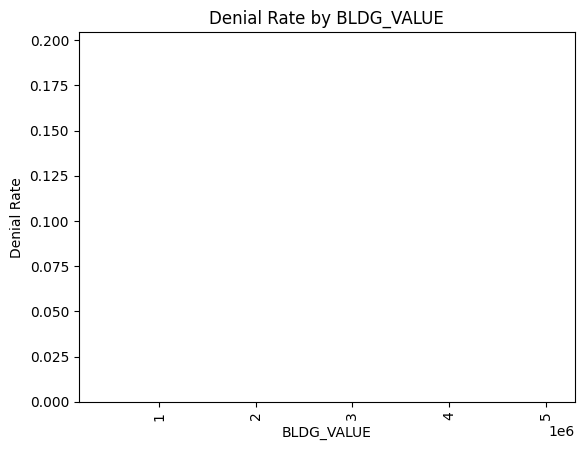

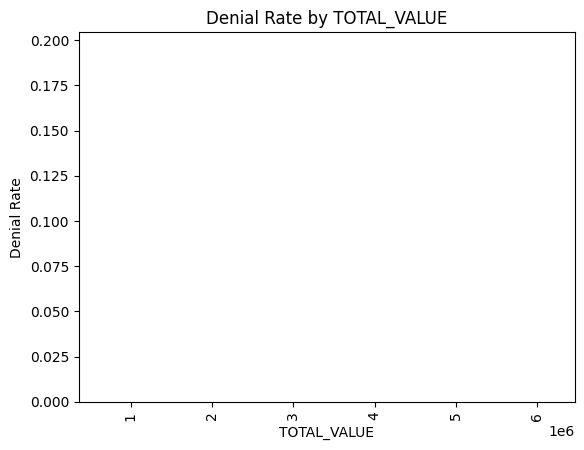

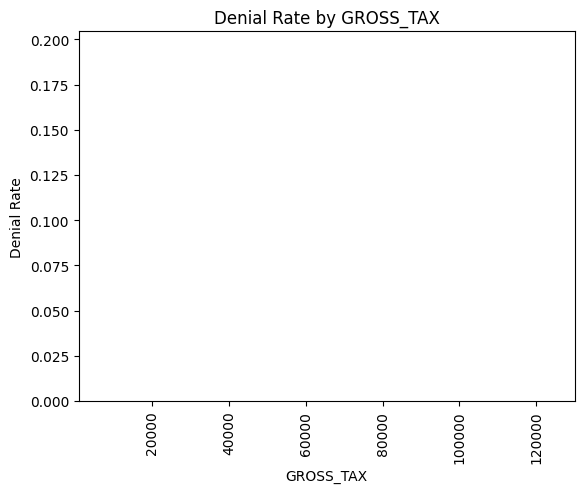

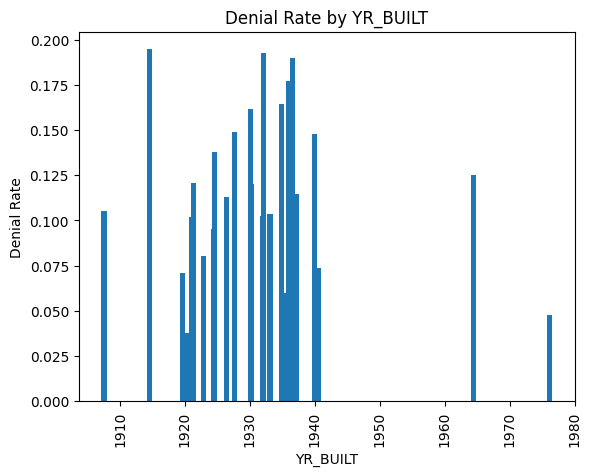

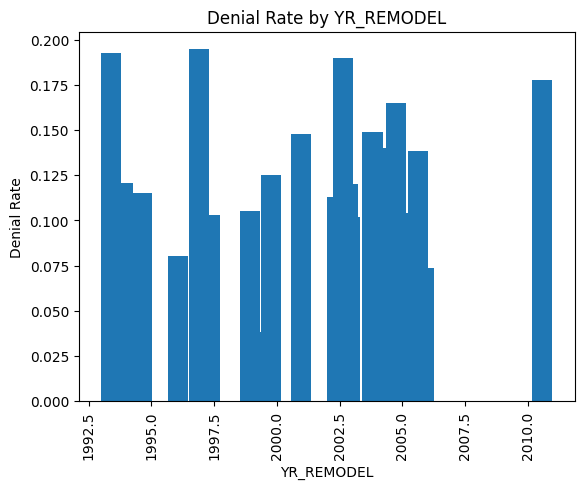

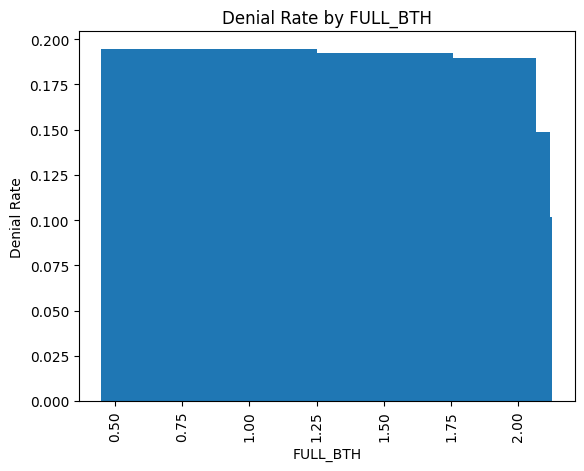

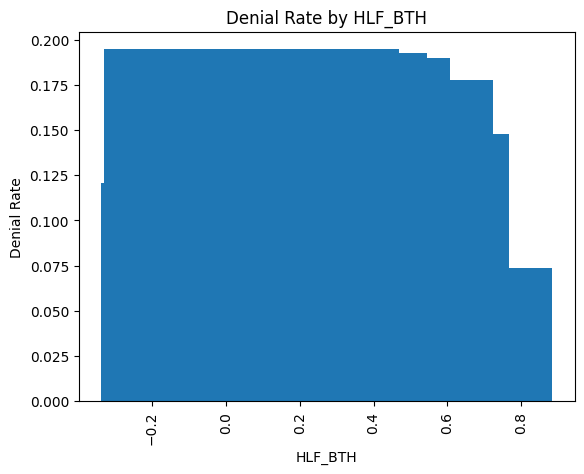

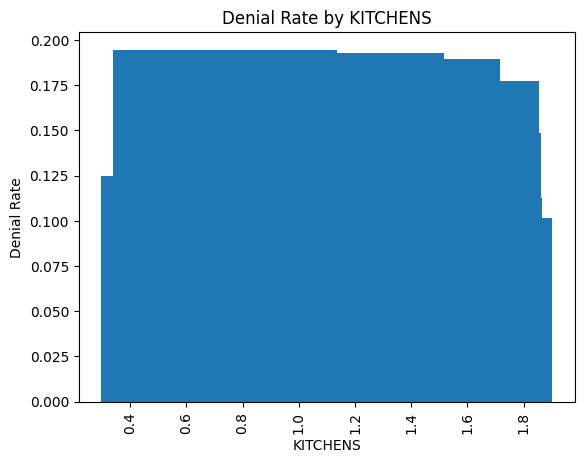

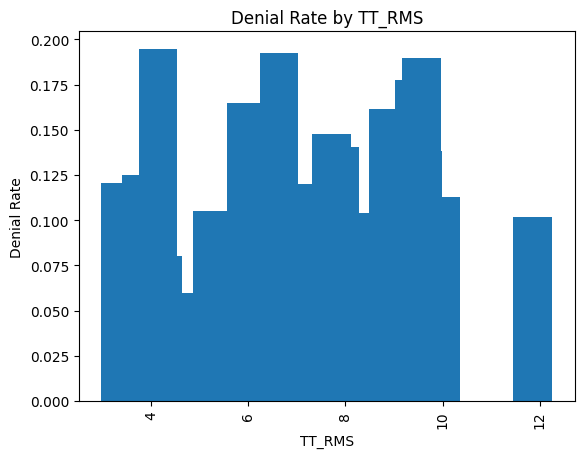

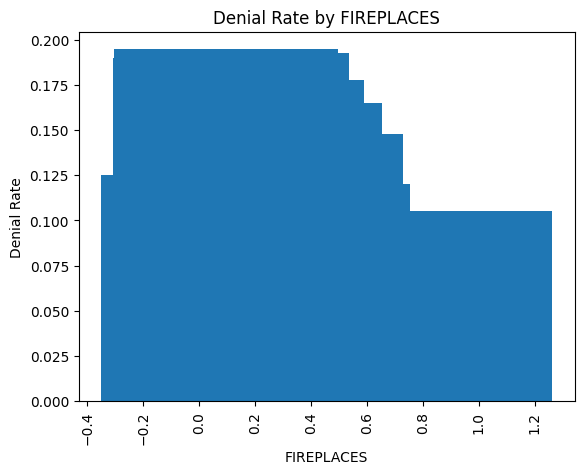

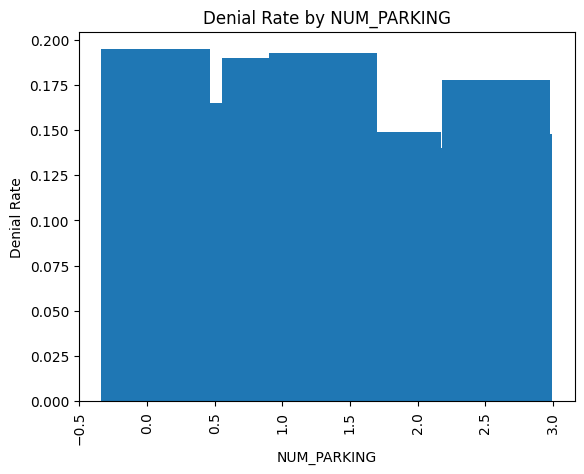

In [90]:
# Clean up city outliers
for city in list(set(denied_df['city'])):
    if len(denied_df[denied_df['city'] == city]) < 3:
        denied_df = denied_df[denied_df['city'] != city]
 
def denied_rate_by_feature(df, column_name):
    labels = [label for label in list(set(df[column_name]))]
    y_vals = [
        ((df[df[column_name] == label][column_name].count()) / (appeals_df[appeals_df[column_name] == label].shape[0])) for label in labels
    ]

    # Note: see that most appeals are approved, < 1000 are denied or denied with prejudice
    plt.title(f"Denial Rate by {column_name}")
    plt.ylabel("Denial Rate")
    plt.xlabel(column_name)
    plt.bar(labels, y_vals)
    plt.xticks(rotation = 90)
    plt.show()

for f in housing_features:
    denied_rate_by_feature(denied_df, f)

In [91]:
voterdata_df = pd.read_csv('../data/VM2Uniform--MA--2021-01-19.tab', sep='\t', encoding='iso-8859-1', usecols=['Residence_Addresses_Zip', 'CommercialData_EstimatedHHIncomeAmount'])

zip_income_data = zip(voterdata_df['Residence_Addresses_Zip'], voterdata_df['CommercialData_EstimatedHHIncomeAmount'])

zip_to_mean_income = dict.fromkeys(voterdata_df['Residence_Addresses_Zip'], None)

for zipcode, income in zip_income_data:
    try:
        if zip_to_mean_income[zipcode] is None:
            zip_to_mean_income[zipcode] = []
        if type(income) == str:
            income = int(income[1:])
            zip_to_mean_income[zipcode].append(income)
    except:
        pass

for zipcode in zip_to_mean_income.keys():
    if zip_to_mean_income[zipcode] is not None:
        zip_to_mean_income[zipcode] = np.mean(zip_to_mean_income[zipcode])

/home/timevdo/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/timevdo/.local/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [92]:
print(appeals_df.columns.to_list())
appeals_df.head()

['address', 'status', 'parent_apno', 'boa_apno', 'appeal_type', 'contact', 'submitted_date', 'received_date', 'hearing_date', 'ever_deferred', 'num_deferrals', 'final_decision_date', 'decision', 'closed_date', 'city', 'zip', 'ward', 'zoning_district', 'project_description', 'submitted_year', 'submitted_month', 'submitted_month_year', 'RES_FLOOR', 'CD_FLOOR', 'RES_UNITS', 'COM_UNITS', 'RC_UNITS', 'LAND_SF', 'GROSS_AREA', 'LIVING_AREA', 'LAND_VALUE', 'BLDG_VALUE', 'TOTAL_VALUE', 'GROSS_TAX', 'YR_BUILT', 'YR_REMODEL', 'FULL_BTH', 'HLF_BTH', 'KITCHENS', 'TT_RMS', 'FIREPLACES', 'NUM_PARKING']


,address,status,parent_apno,boa_apno,appeal_type,contact,submitted_date,received_date,hearing_date,ever_deferred,...,TOTAL_VALUE,GROSS_TAX,YR_BUILT,YR_REMODEL,FULL_BTH,HLF_BTH,KITCHENS,TT_RMS,FIREPLACES,NUM_PARKING
0,14 victoria st dorchester 02125,Community Process,U491529793,BOA1534425,Zoning,Matt Jeske,2023-10-10,2023-10-10,NaN,NaN,...,942321.421175,9287.818301,1924.525026,2005.633858,1.714539,0.193648,1.439994,9.596926,0.164673,1.375339
1,122 seaver st dorchester 02121,Community Process,U491485629,BOA1534528,Zoning,Erika Guerrero,2023-10-10,2023-10-10,NaN,NaN,...,713783.959636,6954.982875,1921.007898,2002.900527,1.725590,0.178915,1.501775,11.856191,0.138115,2.060309
2,9 mckay pl east boston 02128,Community Process,ERT1523974,BOA1534462,Zoning,derric small,2023-10-10,2023-10-10,NaN,NaN,...,796839.862106,9049.341463,1933.113077,2005.241145,1.702687,0.138258,1.451703,8.301746,0.079097,1.031168
3,3927 washington st roslindale 02131,Community Process,ALT1522878,BOA1534015,Zoning,Anthony Ross,2023-10-07,2023-10-10,NaN,NaN,...,661386.218904,6696.773601,1932.117480,2004.379650,1.524667,0.342906,1.256783,7.876732,0.264760,2.255064
4,27 hopkins rd jamaica plain 02130,Community Process,ERT1432001,BOA1534017,Zoning,Anthony Ross,2023-10-07,2023-10-10,NaN,NaN,...,896076.433394,8256.850479,1930.302141,2002.814773,1.540635,0.259680,1.163414,7.386096,0.352650,1.418416


In [93]:
# Add model features
"""
We want
    appeal_type, status -- need to do indexing
    zip, ward, ever_deferred, num_deferrals -- include
    also include income of zip
"""

model_data = pd.DataFrame()

model_data[['zip', 'ward', 'ever_deferred', 'num_deferrals']] = appeals_df[['zip', 'ward', 'ever_deferred', 'num_deferrals']]
model_data['ever_deferred'] = model_data['ever_deferred'].fillna('N')
model_data['ever_deferred'] = model_data['ever_deferred'].replace('N', 0).replace('Y', 1)
model_data['num_deferrals'] = model_data['num_deferrals'].fillna(0)

appeal_list = list(set(appeals_df['appeal_type']))
status_list = list(set(appeals_df['status']))
model_data['appeal_type'] = appeals_df['appeal_type'].apply(lambda a : appeal_list.index(a))

model_data['status'] = appeals_df['status'].apply(lambda s : status_list.index(s))
model_data['year'] = pd.to_datetime(appeals_df['submitted_date']).dt.year
model_data['month'] = pd.to_datetime(appeals_df['submitted_date']).dt.month
model_data['income'] = appeals_df['zip'].apply(lambda z : zip_to_mean_income[z])

for f in housing_features:
    model_data[f] = appeals_df[f]

for f in econ_features:
    model_data[f] = [econ_dct[y][m][f] if y in econ_dct.keys() and m in econ_dct[y].keys() else np.nan for y, m in zip(model_data['year'], model_data['month'])]


#model_data['day'] = pd.to_datetime(appeals_df['submitted_date']).dt.day
model_data['denied'] = appeals_df['decision'].apply(lambda d : 1 if d == 'DeniedPrej' or d == 'Denied' else 0)
model_data = model_data.dropna(axis=0)

print(len(model_data[model_data['denied'] == 1]), len(model_data[model_data['denied'] == 0]))

model_data.head()

470 3071


,zip,ward,ever_deferred,num_deferrals,appeal_type,status,year,month,income,RES_FLOOR,...,hotel_occup_rate,hotel_avg_daily_rate,total_jobs,unemp_rate,labor_force_part_rate,pipeline_unit,pipeline_total_dev_cost,pipeline_sqft,pipeline_const_jobs,denied
2940,2114,5,0,0.0,0,5,2019,12,175360.162799,1.698135,...,0.717,183.2,392118.0,0.02,0.67,1044.0,1.106200e+09,1697970.0,1645.0,0
2941,2130,19,0,0.0,0,3,2019,12,120167.693612,1.885393,...,0.717,183.2,392118.0,0.02,0.67,1044.0,1.106200e+09,1697970.0,1645.0,0
2942,2116,5,0,0.0,0,3,2019,12,179560.276098,1.828774,...,0.717,183.2,392118.0,0.02,0.67,1044.0,1.106200e+09,1697970.0,1645.0,0
2943,2124,17,0,0.0,0,3,2019,12,84890.982734,2.146072,...,0.717,183.2,392118.0,0.02,0.67,1044.0,1.106200e+09,1697970.0,1645.0,0
2947,2127,6,0,0.0,0,3,2019,12,146873.736606,1.903849,...,0.717,183.2,392118.0,0.02,0.67,1044.0,1.106200e+09,1697970.0,1645.0,0


In [94]:
model_data.to_csv('group_f_model_training_data.csv')

In [95]:
print(model_data.shape)

(3541, 41)


Accuracy on testing set =  0.6
RMSE on testing set =  0.4


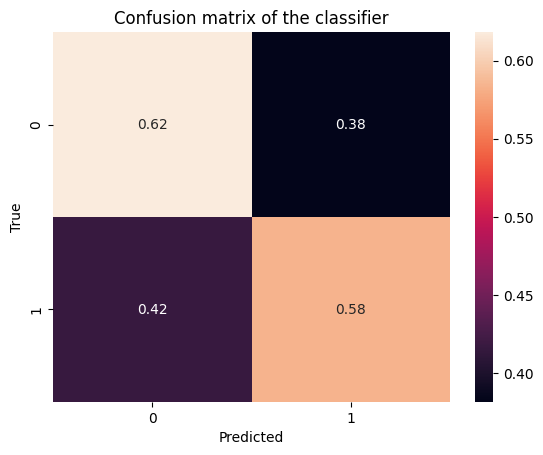

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
import seaborn as sns

#undersample to address skew
S = 1
model_data = model_data.drop(
    model_data[model_data['denied'] == 0].sample(
        int(np.round(S * (len(model_data[model_data['denied'] == 0]) - len(model_data[model_data['denied'] == 1]))))
    ).index
)

X_train, X_test, Y_train, Y_test = train_test_split(
        model_data.drop(['denied'], axis=1),
        model_data['denied'],
        test_size=1/4.0,
        random_state=0
    )

X_train_cpy = X_train.copy()

tree_model = RandomForestClassifier(max_features=None, n_estimators=1000).fit(X_train, Y_train)

Y_test_predictions = tree_model.predict(X_test)
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))
print("RMSE on testing set = ", mean_squared_error(Y_test, Y_test_predictions))

cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

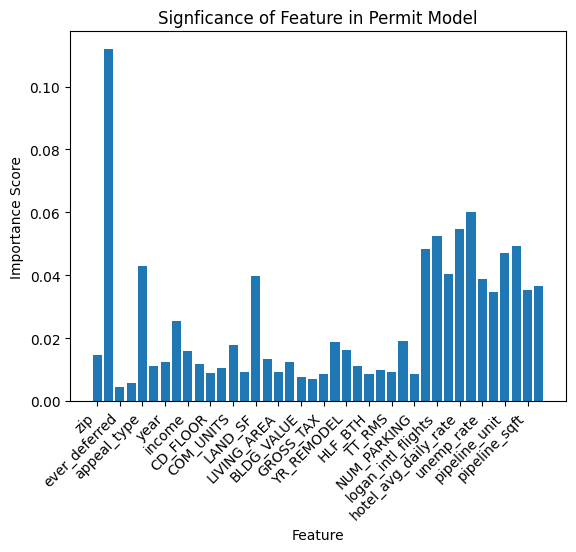

In [71]:
labels = list(X_train_cpy.columns)
vals = tree_model.feature_importances_

assert len(labels) == len(vals)
plt.bar(labels, vals)
plt.title("Signficance of Feature in Permit Model")
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.xticks(np.arange(0,40,2), rotation=45, ha='right')
plt.show()

Accuracy on testing set =  0.574468085106383
RMSE on testing set =  0.425531914893617


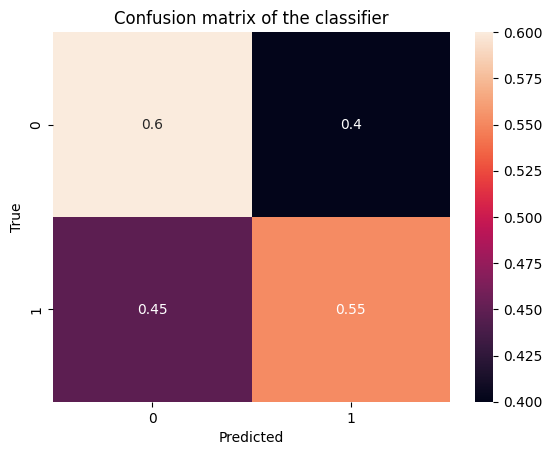

In [72]:
from xgboost import XGBClassifier
bst = XGBClassifier(n_estimators=100, max_depth=150, learning_rate=1, objective='binary:logistic')
bst.fit(X_train, Y_train)
Y_test_predictions = bst.predict(X_test)

print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))
print("RMSE on testing set = ", mean_squared_error(Y_test, Y_test_predictions))

cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

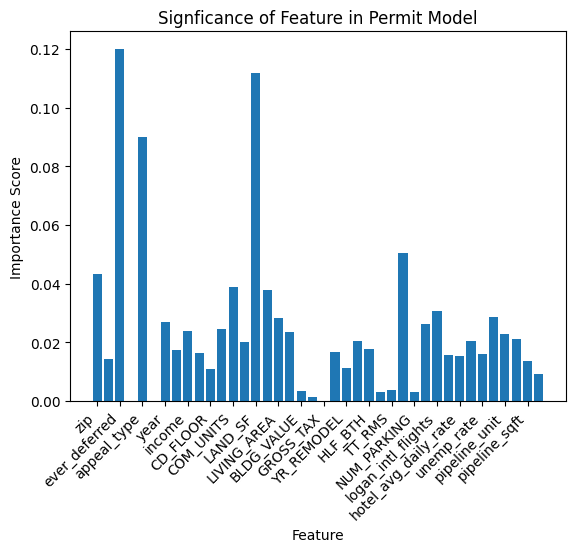

In [73]:
labels = list(X_train_cpy.columns)
vals = bst.feature_importances_

assert len(labels) == len(vals)

plt.bar(labels, vals)
plt.title("Signficance of Feature in Permit Model")
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.xticks(np.arange(0,40,2), rotation=45, ha='right')
plt.show()

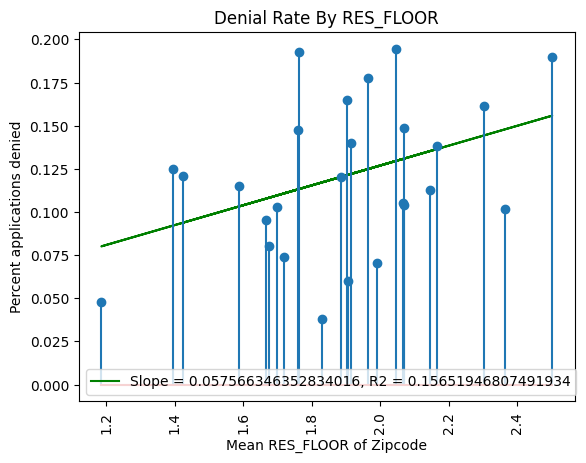

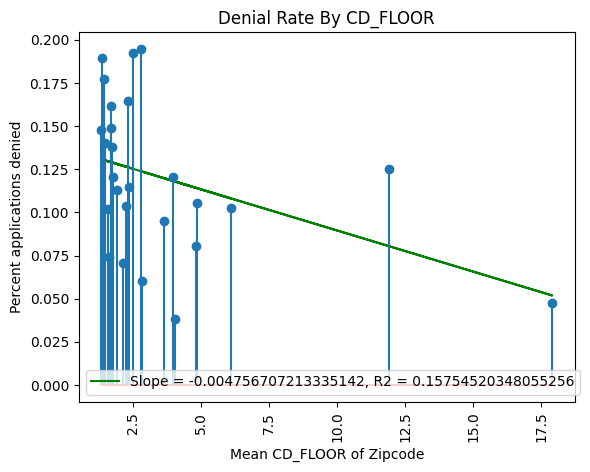

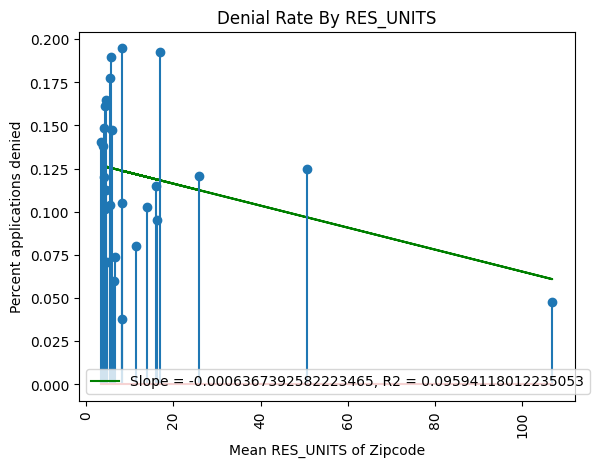

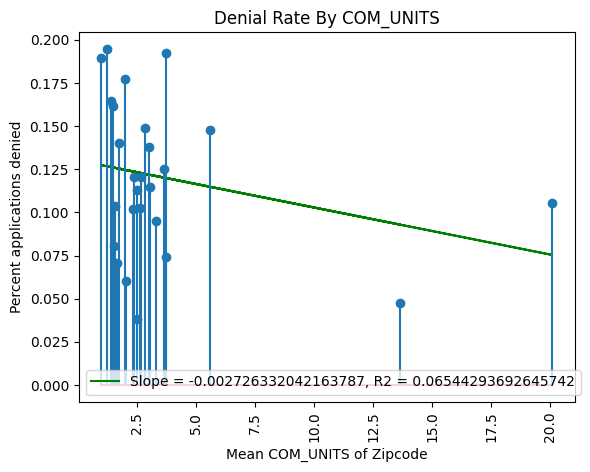

 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  5 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


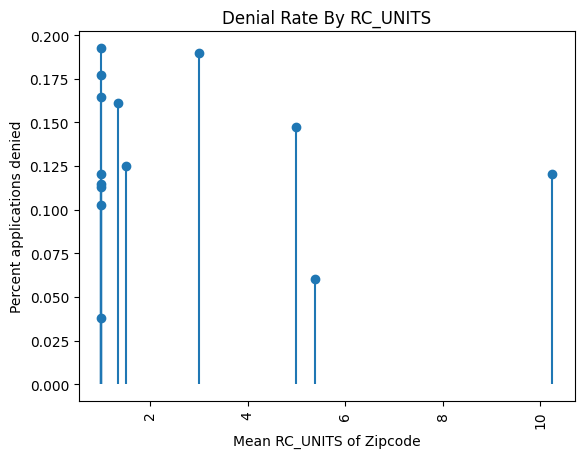

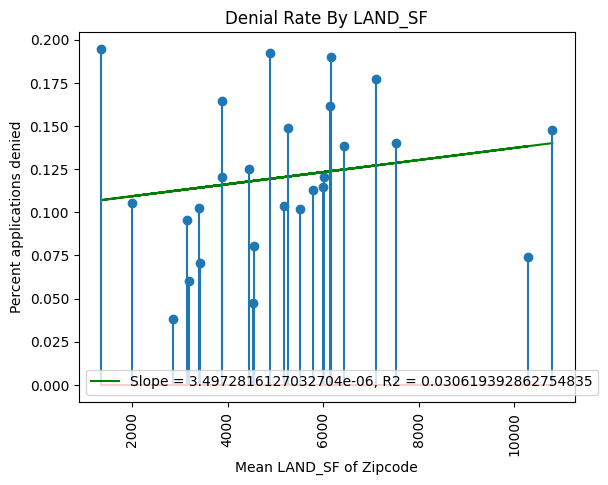

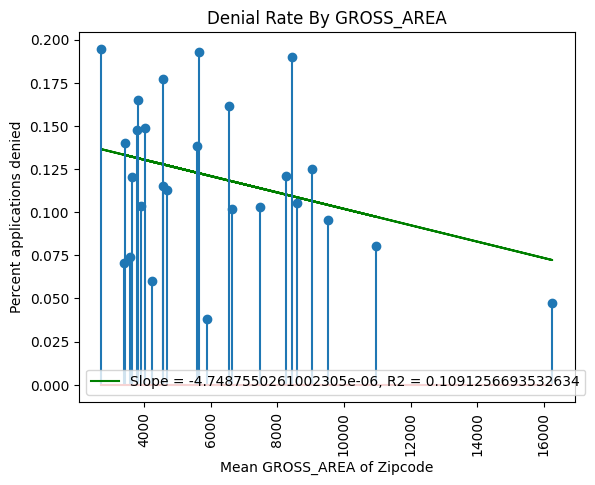

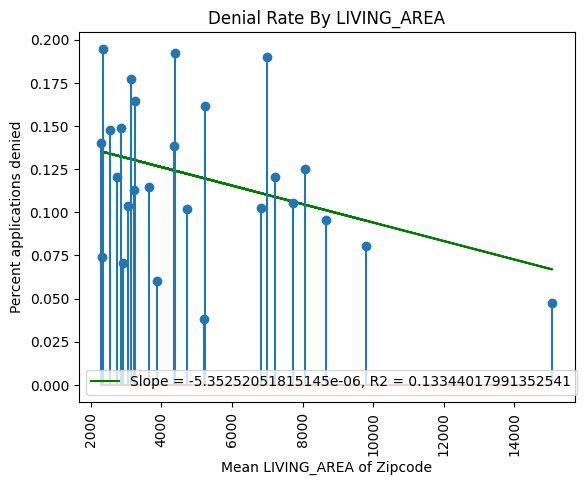

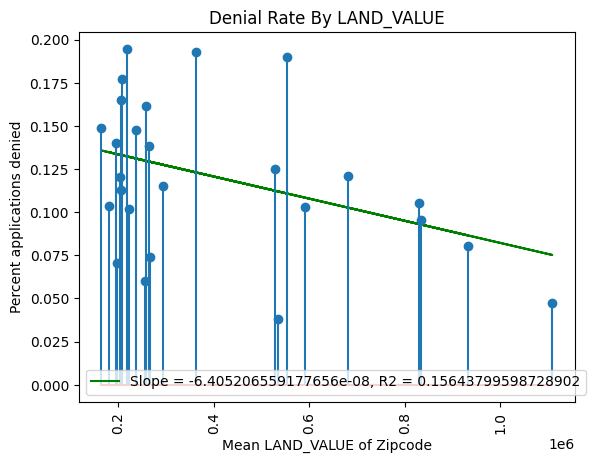

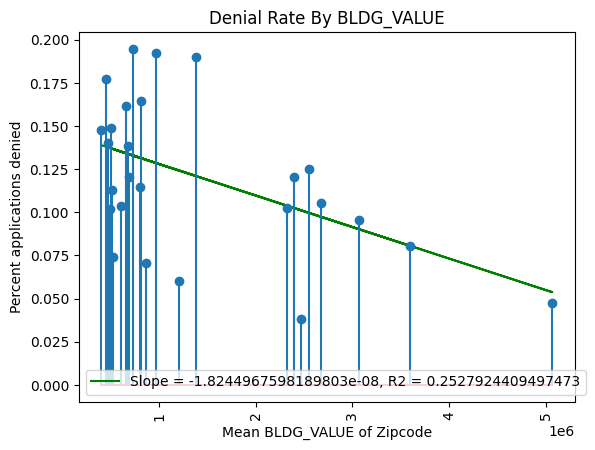

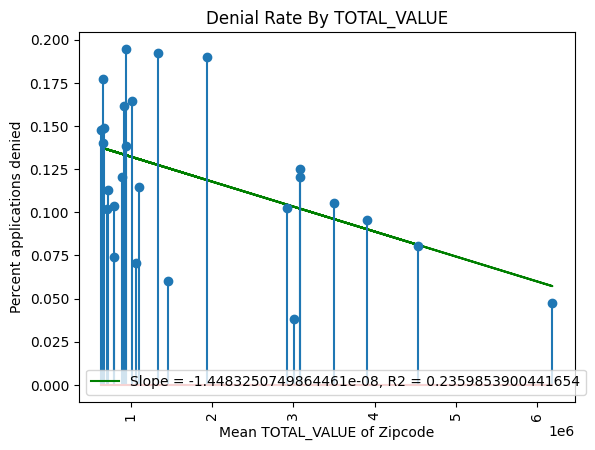

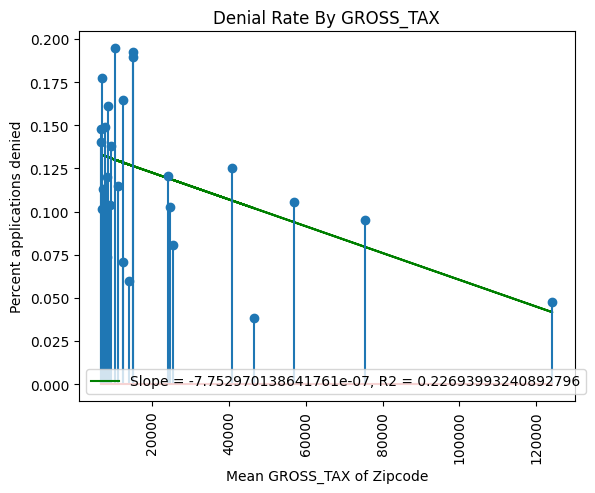

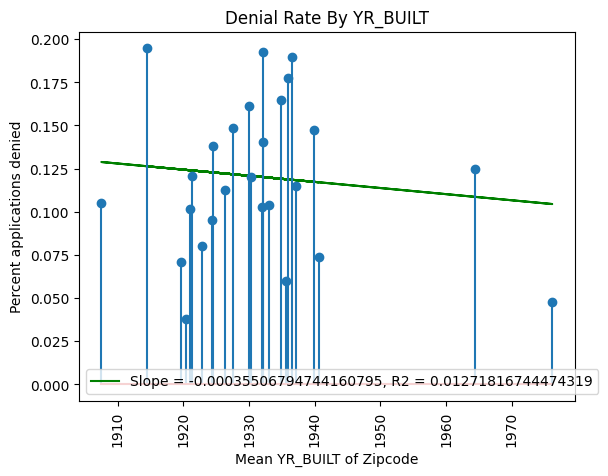

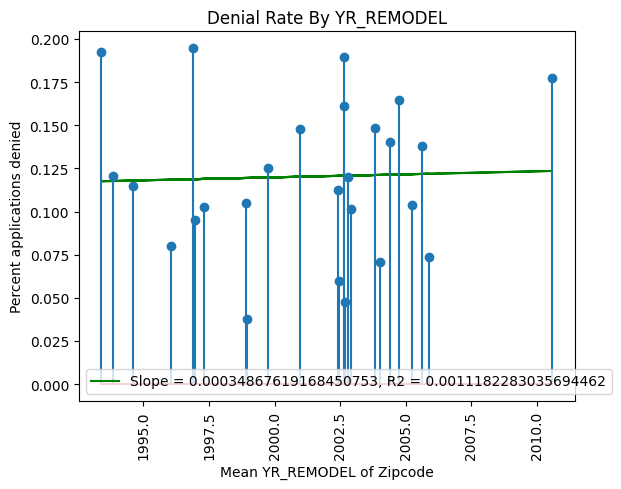

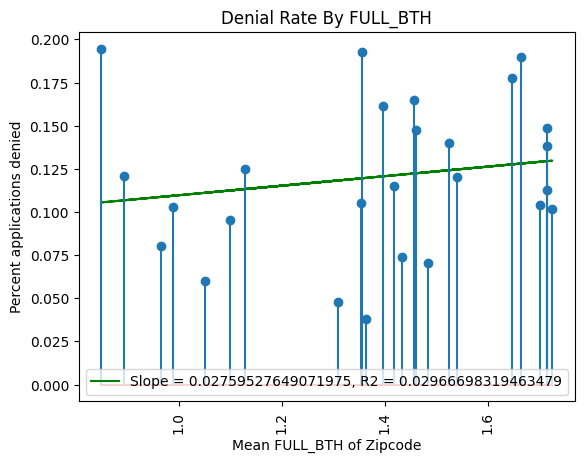

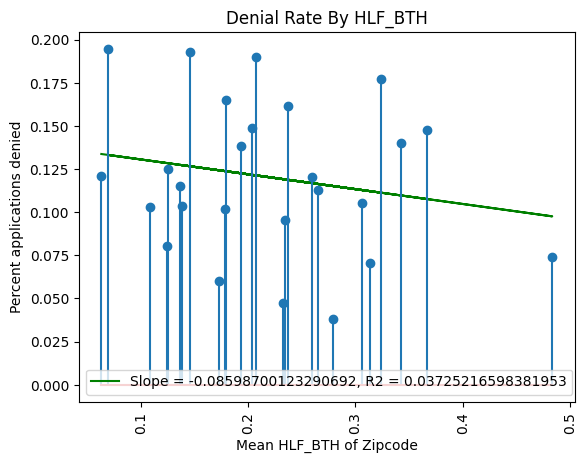

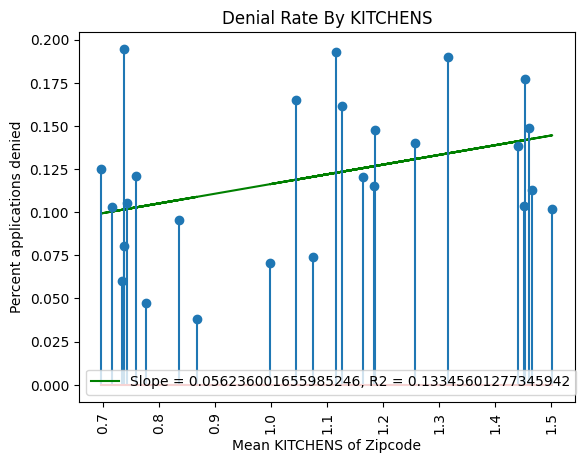

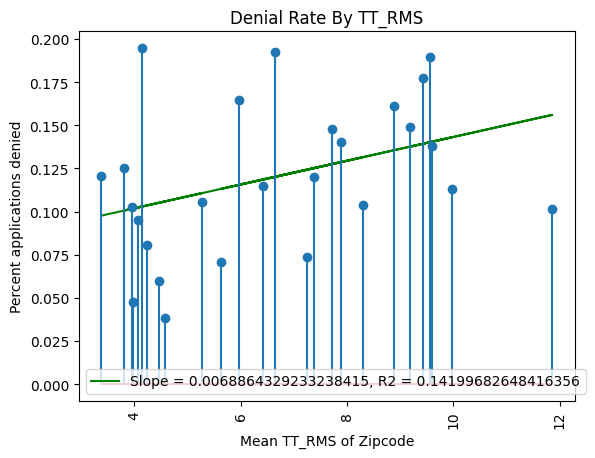

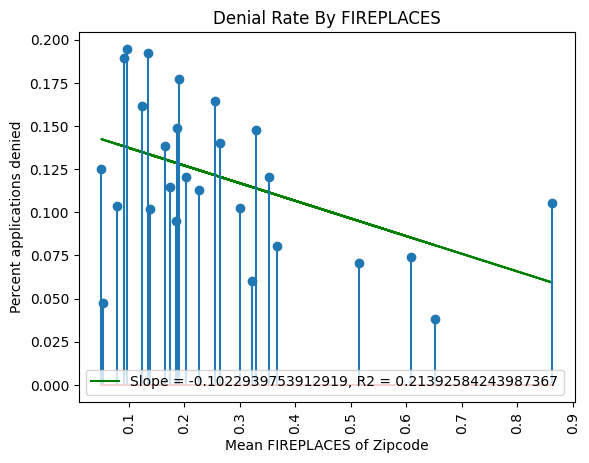

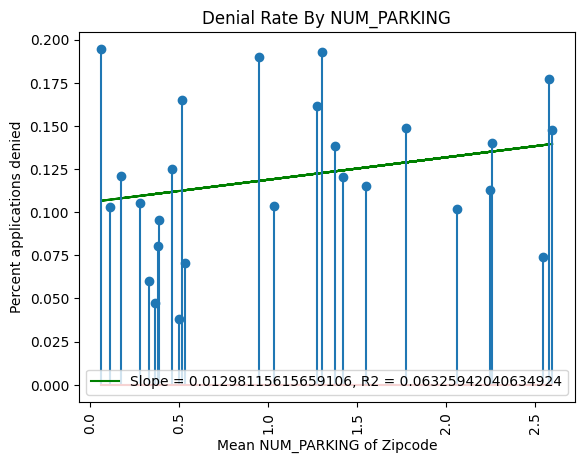

In [74]:
for f in housing_features:
    labels = [label for label in list(set(denied_df['zip']))]
    y_vals = [
        ((denied_df[denied_df['zip'] == label]['zip'].count()) / (appeals_df[appeals_df['zip'] == label].shape[0])) for label in labels
    ]
    x_vals = [housing_dct[int(label)][f] for label in labels]

    try:
        a, b = np.polyfit(x_vals, y_vals, 1)
        r2 = r2_score(y_vals, a*np.array(x_vals)+b)
        plt.plot(x_vals, a*np.array(x_vals)+b, c='green', label=f'Slope = {a}, R2 = {r2}')
        plt.legend()        
    except:
        pass
    
    # Note: see that most appeals are approved, < 1000 are denied or denied with prejudice
    plt.title(f"Denial Rate By {f}")
    plt.ylabel("Percent applications denied")
    plt.xlabel(f"Mean {f} of Zipcode")
    plt.stem(x_vals, y_vals)
    plt.xticks(rotation = 90)
    plt.show()

In [51]:
address_df = pd.read_csv('../data/appeals_latlong.csv')

In [27]:
appeals_df = appeals_df.merge(address_df, on=['address'])
appeals_df.head()

,status,parent_apno,boa_apno,appeal_type,contact,submitted_date,received_date,hearing_date,ever_deferred,num_deferrals,...,zip_y,Residence_Addresses_Latitude_x,Residence_Addresses_Longitude_x,id_x,address,city,zip,Residence_Addresses_Latitude_y,Residence_Addresses_Longitude_y,id_y


In [ ]:
import folium
from folium.plugins import MarkerCluster, HeatMap

boston_map_1 = folium.Map(location=[42.361145, -71.0589], zoom_start=13, control_scale=True)

appeals_df = appeals_df.dropna(subset=[''])